## Modelowanie układów przepływowych - ćwiczenia 
#### (budowa solwera równań płytkiej wody na bazie pakietu PyMPDATA)

NUMBA_THREADING_LAYER = 'omp'        na colabie zeby działało

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [1]:
!pip --quiet install open-atmos-jupyter-utils

### 0. potrzebne pakiety Pythona

In [1]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

### 1. opis układu: symbole i równania

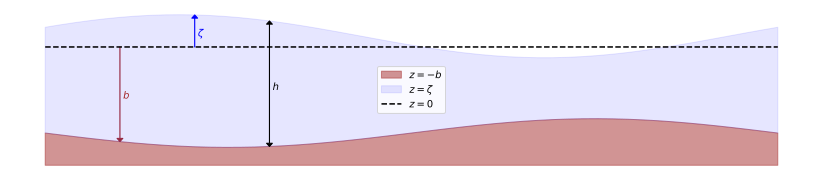

In [2]:
pyplot.figure(figsize=(14.5,3))
pyplot.axis('off')

x = np.linspace(-np.pi, np.pi)
z = np.cos(x+2)/2+.25
b = np.sin(x)/3-2

arrow_kwargs = {'length_includes_head': True, 'head_width': .05}

ix = 5; color='brown'; label='$b$'
pyplot.fill_between(x, b, -2.75, color=color, label=f'$z=-${label}', alpha=.5)
pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
pyplot.annotate(f" {label}", xy=(x[ix], b[ix] + 1), color=color)

ix = 10; color='blue'; label=r'$\zeta$'
pyplot.fill_between(x, z, b, color=color, label=f'$z=${label}', alpha=.1)
pyplot.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
pyplot.annotate(f" {label}", xy=(x[ix], z[ix] - .5), color=color)

ix = 15; color='black'; label='$h$'
pyplot.plot(x, np.full_like(x, 0), linestyle='--', color=color, label='$z=0$')
pyplot.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
pyplot.annotate(f" {label}", xy=(x[ix], -1), color=color)

pyplot.legend(loc=10)
show_plot('symbols')

$$ \zeta(t; x,y) \rightarrow \text{wysokość swobodnej powierzchni względem geoidy (z=0)}$$
$$ b(x,y) \rightarrow \text{batymetria mierzona dodatnio w doół od geoidy}$$
$$ h(t; x,y) = \zeta + b \rightarrow \text{całkowita głębokość kolumny wody} $$
$$ \vec{u} = [u, v]$$
$$
\begin{cases}
  \partial_t h &=&\! -\nabla \cdot (\vec{u}h)\\
  \partial_t (hu) &=&\! -\nabla \cdot (\vec{u}hu) - gh\partial_x\zeta \\
  \partial_t (hv) &=&\! -\nabla \cdot (\vec{u}hv) - gh\partial_y\zeta
\end{cases}
$$

### 2. solwer "hello-world" zbudowany na bazie PyMPDATA

In [5]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, uh_initial: np.ndarray, bathymetry: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }

        # ... (wcześniejsza część kodu)

        # 1. Obliczamy prędkość w środkach komórek (u = pęd / masa)
        # Dodajemy małą liczbę (1e-6), żeby nie dzielić przez zero tam, gdzie jest sucho
        u_center = uh_initial / (h_initial + 1e-15)
        v_center = np.zeros_like(u_center) # Dla rzeki płynącej prosto

        # 2. Przygotowujemy tablice na ścianki (wymiary o 1 większe w odpowiednich osiach)
        u_face = np.zeros((grid[X] + 1, grid[Y]))
        v_face = np.zeros((grid[X], grid[Y] + 1))

        # 3. Prosta interpolacja ze środków na ścianki
        # Dla rzeki o stałej prędkości można po prostu wypełnić stałą wartością,
        # ale poniższy kod jest bardziej uniwersalny (średnia z sąsiednich komórek):
        
        # Środek domeny (średnia arytmetyczna)
        u_face[1:-1, :] = 0.5 * (u_center[:-1, :] + u_center[1:, :])
        
        # Brzegi (Wlot i Wylot) - kopiujemy wartość z najbliższej komórki
        u_face[0, :] = u_center[0, :]   # Lewy brzeg (wlot)
        u_face[-1, :] = u_center[-1, :] # Prawy brzeg (wylot)

        # 4. Inicjalizujemy VectorField poprawnymi danymi
        self.advector = VectorField((u_face, v_face), **kwargs)





        # self.advector = VectorField((
        #         np.zeros((grid[X] + 1, grid[Y])),
        #         np.zeros((grid[X], grid[Y] + 1))
        #     ), **kwargs
        # )
        self.bathymetry = bathymetry
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        ## 3 pary klucz wartość z advectees (h, uh, vh)

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    ## __getitem__ odpowiada, ze jak wezme a = A() to a[k] daje k-ty element słownika (get() daje widok na to, a nie kopie)
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None) 
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1): 
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output
    ### __call__ odpowiada za nawias okrągły A() (tak jakby to była funkcja)

### 3. Przykładowa symulacja

In [7]:
grid = (50, 40)
bathymetry = np.tile(
    np.linspace(0, 1, grid[1]),
    (grid[0], 1)    #powielamy w x grid[0] razy, a w y nie powielamy
)

uh_initial = bathymetry.copy() * 0.01
h_initial = bathymetry.copy()
h_initial[
    grid[0] // 2 - grid[0] // 20:
    grid[0] // 2 + grid[0] // 20,
    grid[1] // 2 - grid[1] // 20:
    grid[1] // 2 + grid[1] // 20
] += .025

output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial, bathymetry=bathymetry
)(
    nt=60, g=10, dt_over_dxy=(.25, .25), outfreq=3
)

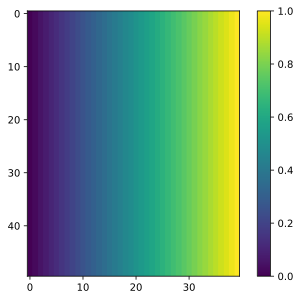

In [8]:
pyplot.imshow(bathymetry)
pyplot.colorbar()

# 3.1

In [5]:
import numpy as np

# --- proste stuby zastępujące brakujące klasy ---
class Options:
    def __init__(self, nonoscillatory=True, infinite_gauge=True, n_halo=1):
        self.nonoscillatory = nonoscillatory
        self.infinite_gauge = infinite_gauge
        self.n_halo = n_halo

class boundary_conditions:
    class Constant:
        def __init__(self, value=0):
            self.value = value

class Stepper:
    def __init__(self, options, grid):
        # prosta weryfikacja typów
        self.options = options
        self.grid = grid

class ScalarField:
    def __init__(self, arr, **kwargs):
        self._arr = np.array(arr, dtype=float)
    def get(self):
        return self._arr
    # advance stub: do nothing
    def advance(self, n_steps=1):
        pass

class VectorField:
    def __init__(self, comps, **kwargs):
        self._comps = [np.array(c, dtype=float) for c in comps]
    def get_component(self, axis):
        return self._comps[axis]

class Solver:
    def __init__(self, stepper, advectee, advector):
        self.advectee = advectee
        self.advector = advector
    def advance(self, n_steps=1):
        # simple placeholder: do nothing
        pass

# --- zmodyfikowany integrator korzystający ze stubów ---
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, bathymetry: np.ndarray,
                 u_initial: np.ndarray = None, v_initial: np.ndarray = None,
                 uh_initial: np.ndarray = None, vh_initial: np.ndarray = None,
                 options: Options = None):
        options = options or Options()
        X, Y = 0, 1
        grid = h_initial.shape
        nx, ny = grid
        stepper = Stepper(options=options, grid=grid)
        kwargs = {'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
                  'halo': options.n_halo}
        self.bathymetry = bathymetry

        # przygotowanie uh, vh (staggered)
        if uh_initial is None:
            uh_init = np.zeros((nx + 1, ny))
            if u_initial is not None:
                u_face = 0.5 * (u_initial[:-1, :] + u_initial[1:, :])
                h_face = 0.5 * (h_initial[:-1, :] + h_initial[1:, :])
                uh_init[1:-1, :] = h_face * u_face
                uh_init[0, :] = h_initial[0, :] * u_initial[0, :]
                uh_init[-1, :] = h_initial[-1, :] * u_initial[-1, :]
        else:
            uh_init = uh_initial

        if vh_initial is None:
            vh_init = np.zeros((nx, ny + 1))
            if v_initial is not None:
                v_face = 0.5 * (v_initial[:, :-1] + v_initial[:, 1:])
                h_face = 0.5 * (h_initial[:, :-1] + h_initial[:, 1:])
                vh_init[:, 1:-1] = h_face * v_face
                vh_init[:, 0] = h_initial[:, 0] * v_initial[:, 0]
                vh_init[:, -1] = h_initial[:, -1] * v_initial[:, -1]
        else:
            vh_init = vh_initial

        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(uh_init, **kwargs),
            "vh": ScalarField(vh_init, **kwargs),
        }
        self.advector = VectorField((
            np.zeros((grid[X] + 1, grid[Y])),
            np.zeros((grid[X], grid[Y] + 1))
        ), **kwargs)
        self.solvers = {k: Solver(stepper, v, self.advector) for k, v in advectees.items()}

    def __getitem__(self, key):
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """
        axis: 0 for x-direction (uh), 1 for y-direction (vh)
        key: "uh" or "vh"
        mask: boolean mask for cell-centered h (shape (nx,ny))
        dt_over_dxy: tuple (dt/dx, dt/dy)
        """
        h = self['h']  # shape (nx, ny)
        momentum = self[key]  # uh: (nx+1, ny) or vh: (nx, ny+1)

        if axis == 0:
            # uh lives on vertical faces: shape (nx+1, ny)
            # compute face-centered h by averaging adjacent cell-centered h in x
            # h_face has shape (nx+1, ny) if we pad boundaries by copying edge cells
            h_face = np.zeros_like(momentum)
            # interior faces: average h[i-1] and h[i]
            h_face[1:-1, :] = 0.5 * (h[:-1, :] + h[1:, :])
            # boundary faces: copy adjacent cell h (or use one-sided)
            h_face[0, :] = h[0, :]
            h_face[-1, :] = h[-1, :]

            # mask_face: where h_face > eps
            mask_face = h_face > 1e-7

            # velocity on faces
            velocity_face = np.zeros_like(momentum)
            np.divide(momentum, h_face, where=mask_face, out=velocity_face)

            # velocity at cell boundaries used for courant: we need values at interior faces
            # velocity_at_cell_boundaries shape should match courant array shape:
            # take interior faces (1:-1) and add half-difference along axis 0
            vel_interior = velocity_face[1:-1, :] + np.diff(velocity_face, axis=0) / 2.0
            # get courant_number view from advector component
            courant_number = self.advector.get_component(0)[1:-1, :]
            courant_number[:] = vel_interior * dt_over_dxy[0]

        else:
            # axis == 1: vh lives on horizontal faces: shape (nx, ny+1)
            h_face = np.zeros_like(momentum)
            # interior faces in y: average h[:, j-1] and h[:, j]
            h_face[:, 1:-1] = 0.5 * (h[:, :-1] + h[:, 1:])
            # boundary faces
            h_face[:, 0] = h[:, 0]
            h_face[:, -1] = h[:, -1]

            mask_face = h_face > 1e-7
            velocity_face = np.zeros_like(momentum)
            np.divide(momentum, h_face, where=mask_face, out=velocity_face)

            vel_interior = velocity_face[:, 1:-1] + np.diff(velocity_face, axis=1) / 2.0
            courant_number = self.advector.get_component(1)[:, 1:-1]
            courant_number[:] = vel_interior * dt_over_dxy[1]

        # bezpieczne sprawdzenie Couranta (nan-aware)
        max_c = np.nanmax(np.abs(courant_number))
        assert max_c <= 1, f"Courant {max_c} > 1"

        
    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1): 
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output


# --- przykład użycia (Twoja bathymetria + prędkość rzeki) ---
grid = (50, 40)
nx, ny = grid
bathymetry = np.tile(np.linspace(0, 1, ny), (nx, 1))
crest_width = ny // 10
crest_x_start = nx // 2 - nx // 40
crest_x_end = nx // 2 + nx // 40
crest_y_start = ny // 2 - crest_width // 2
crest_y_end = ny // 2 + crest_width // 2
bathymetry[crest_x_start:crest_x_end, crest_y_start:crest_y_end] += 0.2

h_initial = bathymetry.copy()
h_initial += 0.3
h_initial[nx // 2 - nx // 20 : nx // 2 + nx // 20, ny // 2 - ny // 20 : ny // 2 + ny // 20] += .025

u_initial = np.full((nx, ny), 0.5)
v_initial = np.full((nx, ny), 1.0)

integrator = ShallowWaterEquationsIntegrator(
    h_initial=h_initial,
    bathymetry=bathymetry,
    u_initial=u_initial,
    v_initial=v_initial
)

output = integrator(nt=10, g=10.0, dt_over_dxy=(0.1, 0.1), outfreq=2)
print("Simulation ran; saved frames:", {k: len(v) for k, v in output.items()})
print("Shapes: h", output['h'][0].shape, "uh", output['uh'][0].shape, "vh", output['vh'][0].shape)


ValueError: operands could not be broadcast together with shapes (49,40) (50,40) 

### 4. Wizualizacja


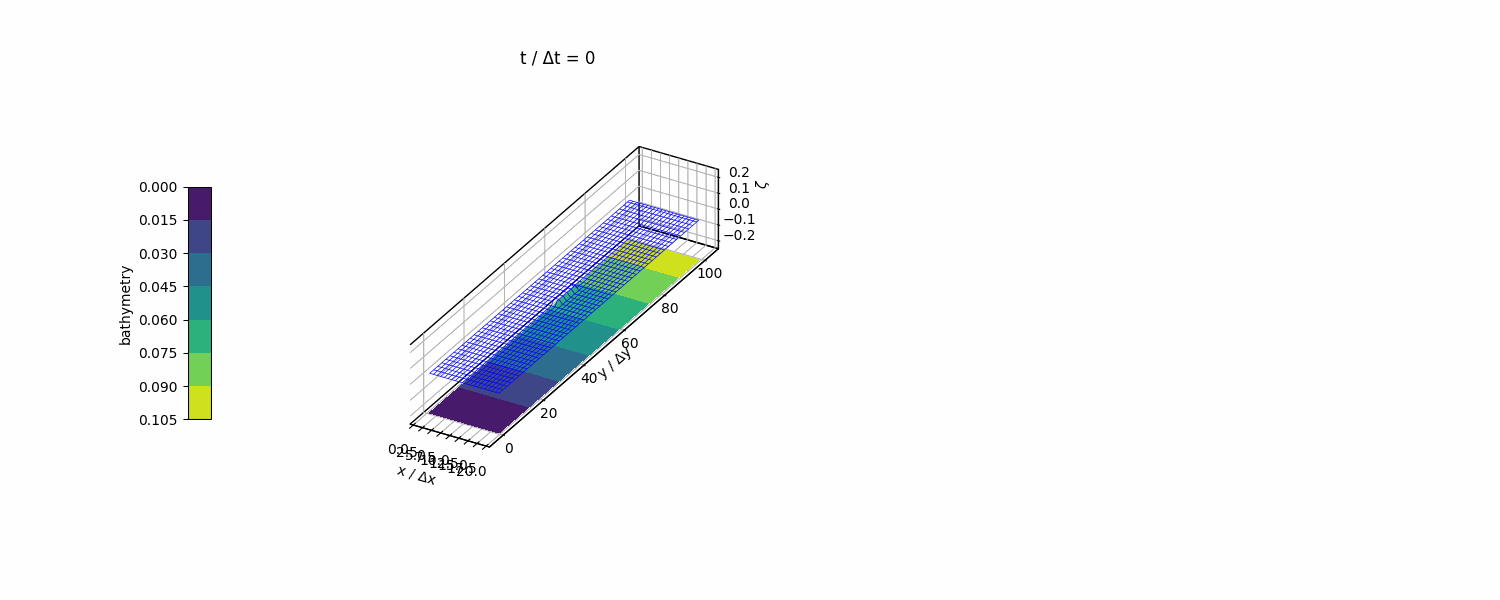

HTML(value="<a href='./tmp7l65rvp9.gif' target='_blank'>./tmp7l65rvp9.gif</a><br>")

In [9]:
def plot(frame, *, zlim=(-.25, 0.25)):
    psi = output['h'][frame] - bathymetry
    # Pobieramy wymiary siatki do ustalenia proporcji
    nx, ny = psi.shape 
    
    xi, yi = np.indices(psi.shape)
    
    # Zwiększyłem nieco figsize, żeby długa rzeka się ładnie mieściła
    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 6))
    
    ax.plot_wireframe(xi+.5, yi+.5, psi, color='blue', linewidth=.5)
    
    # --- NOWY FRAGMENT: Ustawienie proporcji ---
    # Ustawiamy proporcje pudełka (Box Aspect).
    # X i Y biorą swoje rzeczywiste wymiary (nx, ny).
    # Z jest ustawione "na sztywno" (np. jako średnia z boków lub inna wartość),
    # bo przy prawdziwej skali (głębokość < 1m vs długość rzeki 100m)
    # wykres byłby płaski jak kartka papieru.
    z_scale = max(nx, ny) / 5  # Eksperymentalny współczynnik "wyciągnięcia" w górę
    ax.set_box_aspect((nx, ny, z_scale))
    # -------------------------------------------

    ax.set(zlim=zlim, proj_type='ortho', title=f"t / Δt = {frame}", zlabel=r"$\zeta$")
    
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)
        
    for axis in ('x', 'y'):
        getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")
        
    pyplot.colorbar(
        ax.contourf(xi+.5, yi+.5, bathymetry, zdir='z', offset=zlim[0]),
        pad=.1, aspect=10, fraction=.02, label='bathymetry', location='left'
    ).ax.invert_yaxis()
    
    return fig
show_anim(plot, range(len(output['h'])))

## Projekt zaliczeniowy 

#### sprawozdanie: obliczenia, wizualizacje i kompilacja pdf na GitHub Actions (pdf jako artefakt, maksimum 3 strony tekstu, w tym maksimum połowa to rysunki)

- fizyka/numeryka:
  - określ i opisz układ i parametry symulacji (warunek początkowy, batymetria, siatka, parametry fizyczne)
  - zdefiniuj pytanie, na które szukasz odpowiedzi (np. zależność wysokości fali przy brzegu od ...)
  - sprawdź i udokumentuj analizę zależności wyników od podwojenia rozdzielczości czasowej i przestrzennej
- wizualizacja:
  - pole (wektorowe) prędkości
  - powierzchnia płynu (zarówno 2D, jak i przekroje)
  - wyłącznie grafika wektorowa

#### Sposób wysłania
- w ciągu tygodnia: zgłoszenie przez UPEL pytania, na które będziemy poszukiwać odpowiedzi
- w ciągu dwóch tygodni: wrzucenie przez UPEL odnośnika do "runu" generującego artefakt ze sprawozdaniem (/actions/runs/...), który pozwala oceniającym jednoznacznie zlokalizować kod oraz logi wykonania symulacji.

#### Sposób oceny
- 25% fizyka (opis modelu, opis układu i parametrów)
- 25% numeryka (opis siatki, analiza zbieżności)
- 25% technikalia (odtwarzalność, jakość wykresów i poprawność opisów osi, czytelność kodu)
- 10% + 15% postawienie pytania i interpretacja wyników